<a href="https://colab.research.google.com/github/avikumart/LLM-GenAI-Transformers-Notebooks/blob/main/DeepLearningFiles/classification_kerastuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build a model to predict customer churn



### Read the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

ds = pd.read_csv("/content/drive/MyDrive/AI in healthcare - projects docs/Churn_Modelling.csv")

In [ ]:
ds.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
ds.Exited.value_counts(normalize=True)

,proportion
Exited,
0,0.7963
1,0.2037


### Drop the columns which are unique for all users like IDs

### RowNumber, CustomerId, and Surname are unique hence we are dropping it

In [ ]:
ds = ds.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
ds['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Distinguish the feature and target set

In [ ]:
X = ds.iloc[:,0:10].values # Credit Score through Estimated Salary
y = ds.iloc[:,10].values # Exited

### Encoding categorical (string based) data. Country: there are 3 options: France, Spain and Germany. This will convert those strings into scalar values for analysis.

In [ ]:
from sklearn.preprocessing import LabelEncoder

print(X[:8,1], '... will now become: ')

label_X_country_encoder = LabelEncoder()
X[:,1] = label_X_country_encoder.fit_transform(X[:,1])
print(X[:8,1])

['France' 'Spain' 'France' 'France' 'Spain' 'Spain' 'France' 'Germany'] ... will now become: 
[0 2 0 0 2 2 0 1]


### We will do the same thing for gender. this will be binary in this dataset

In [ ]:
print(X[:6,2], '... will now become: ')

label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


### The Problem here is that we are treating the countries as one variable with ordinal values (0 < 1 < 2). Therefore, one way to get rid of that problem is to split the countries into respective dimensions. Gender does not need this as it is binary

### Converting the string features into their own dimensions. Gender doesn't matter here because its binary

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transform = ColumnTransformer([("countries", OneHotEncoder(), [1])], remainder="passthrough") # 1 is the country column
X = transform.fit_transform(X)

In [ ]:
X.shape

(10000, 12)

In [ ]:
X[:1]

array([[1.0, 0.0, 0.0, 619, 0, 42, 2, 0.0, 1, 1, 1, 101348.88]],
      dtype=object)

In [ ]:
# A 0 on two countries means that the country has to be the one variable which wasn't included
# This will save us from the problem of using too many dimensions
X = X[:,1:] # Got rid of Spain as a dimension.

In [ ]:
X[:1]

array([[0.0, 0.0, 619, 0, 42, 2, 0.0, 1, 1, 1, 101348.88]], dtype=object)

### Divide the data set into Train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

### Normalize the train and test data

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape, y_train.shape

((8000, 11), (8000,))

FIRST BUILD A SIMPLE NEURALNET TO TRAIN AND THEN BUILD THE TUNABLE KERAS MODEL

In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import kerastuner as kt
import keras
from keras.datasets import reuters
from tensorflow.keras import models, layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Activation, Dense
import matplotlib.pyplot as plt
from kerastuner import HyperModel

<ipython-input-22-10c6b772950e>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
print(tf.__version__)
print(kt.__version__)

2.18.0
1.0.5


In [ ]:
from tensorflow.keras.models import Sequential
# Initializing the ANN
classifier = Sequential()
classifier.add(Dense(name='Hidden_1',units=8, input_dim = 11,activation = 'relu'))
classifier.add(Dense(name='Hidden_2',units=4,activation = 'relu'))
classifier.add(Dense(name='output',units=1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_1 (Dense)                │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#optimizer = tf.keras.optimizers.Adam()
# Compile the model
#classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
classifier.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [ ]:
history= classifier.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32, callbacks=[es])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5638 - loss: 0.6951 - val_accuracy: 0.7975 - val_loss: 0.5347
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.5098 - val_accuracy: 0.7975 - val_loss: 0.4617
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8034 - loss: 0.4514 - val_accuracy: 0.7985 - val_loss: 0.4396
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7970 - loss: 0.4345 - val_accuracy: 0.8055 - val_loss: 0.4263
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8058 - loss: 0.4238 - val_accuracy: 0.8220 - val_loss: 0.4166
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8169 - loss: 0.4233 - val_accuracy: 0.8290 - val_loss: 0.4067
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8241 - loss: 0.4097 - val_accuracy: 0.8340 - val_loss: 0.3968
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8227 - loss: 0.4015 - val_accu

In [ ]:
import matplotlib.pyplot as plt

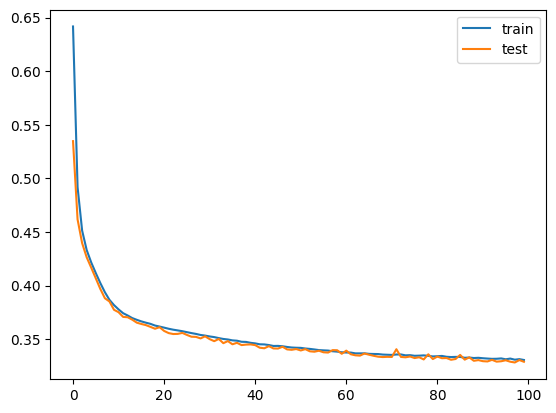

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

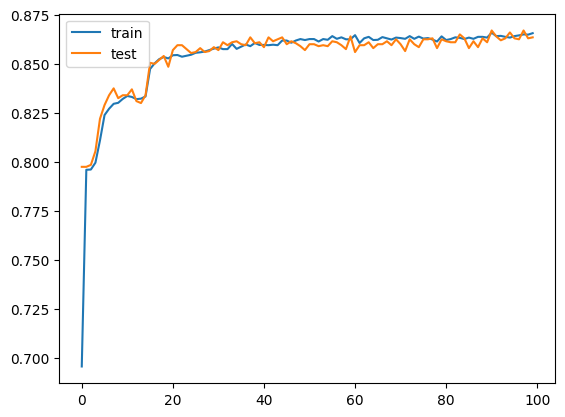

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [34]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

In [35]:
def build_model_fixed_HL(hp):
    model = Sequential()
    model.add(Dense(name='hidden_1',units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(Dense(name='hidden_2',units=hp.Int('units2',
                                        min_value= ,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3])),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [36]:
tuner = Hyperband(build_model_fixed_HL,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 2,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt_fl2')

In [37]:
new_var = tuner.search_space_summary()
new_var

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [38]:
tuner.search(X_train, y_train,validation_data=(X_test,y_test))

Trial 46 Complete [00h 00m 27s]
val_accuracy: 0.8669999837875366

Best val_accuracy So Far: 0.8690000176429749
Total elapsed time: 00h 07m 18s


In [ ]:
tuner.results_summary( )

Results summary
Results in my_dir/intro_to_kt_fl2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0043 summary
Hyperparameters:
units: 224
units2: 480
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8684999942779541

Trial 0030 summary
Hyperparameters:
units: 320
units2: 128
learning_rate: 0.01
tuner/epochs: 5
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0024
Score: 0.8679999709129333

Trial 0037 summary
Hyperparameters:
units: 128
units2: 256
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8679999709129333

Trial 0015 summary
Hyperparameters:
units: 160
units2: 224
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 3
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0010
Score: 0.8675000071525574

Trial 0010 summary
Hyperparameters:
units: 160
units2: 224
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 2
tuner/

In [39]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, The optimal number of units in the second densely-connected
layer is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384, The optimal number of units in the second densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.01.



In [42]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=512,
                                            step=16),
                               activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile( optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [43]:
tuner2 = kt.Hyperband(build_model,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     factor = 2,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt3')

In [44]:
tuner2.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [45]:
tuner2.search(X_train, y_train,

             validation_data=(X_test,y_test))

Trial 92 Complete [00h 00m 31s]
val_accuracy: 0.8665000200271606

Best val_accuracy So Far: 0.871999979019165
Total elapsed time: 00h 20m 56s


In [46]:
tuner2.results_summary()

Results summary
Results in my_dir/intro_to_kt3
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0089 summary
Hyperparameters:
num_layers: 2
units_0: 424
learning_rate: 0.0001
units_1: 504
units_2: 8
units_3: 312
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.871999979019165

Trial 0079 summary
Hyperparameters:
num_layers: 3
units_0: 440
learning_rate: 0.0001
units_1: 104
units_2: 88
units_3: 408
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8700000047683716

Trial 0086 summary
Hyperparameters:
num_layers: 4
units_0: 360
learning_rate: 0.0001
units_1: 344
units_2: 472
units_3: 8
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8700000047683716

Trial 0068 summary
Hyperparameters:
num_layers: 2
units_0: 152
learning_rate: 0.01
units_1: 248
units_2: 168
units_3: 200
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8694999814033508

In [47]:
best_hps=tuner2.get_best_hyperparameters(num_trials=1)[0]

In [48]:
model_tuned = tuner2.hypermodel.build(best_hps)

In [49]:
model_tuned.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32, callbacks=[es])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7736 - loss: 0.5155 - val_accuracy: 0.8225 - val_loss: 0.4110
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8272 - loss: 0.4095 - val_accuracy: 0.8475 - val_loss: 0.3807
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8411 - loss: 0.3894 - val_accuracy: 0.8555 - val_loss: 0.3614
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8476 - loss: 0.3705 - val_accuracy: 0.8600 - val_loss: 0.3541
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8469 - loss: 0.3634 - val_accuracy: 0.8615 - val_loss: 0.3445
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8560 - loss: 0.3470 - val_accuracy: 0.8620 - val_loss: 0.3410
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8597 - loss: 0.3419 - val_accuracy: 0.8605 - val_loss: 0.3401
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8595 - loss: 0.3407 - val

In [50]:
model_tuned.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (32, 424)              │         5,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 504)              │       214,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1)                │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,381 (2.52 MB)

 Trainable params: 219,793 (858.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 439,588 (1.68 MB)

In [54]:
import os

In [55]:
os.chdir ("/content/drive/MyDrive/AI in healthcare - projects docs/")

In [56]:
model_tuned.save('tunedmodel.h5')

In [57]:
model_new_tuned = keras.models.load_model('tunedmodel.h5')

In [58]:
model_new_tuned.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (32, 424)              │         5,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 504)              │       214,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1)                │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,795 (858.58 KB)

 Trainable params: 219,793 (858.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Incorporating Class Balancing through ADASYN AND SMOTE


In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter

In [ ]:
ada = ADASYN(random_state=42)

In [ ]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 6368, 1: 1632})


In [ ]:
pd.Series(y_train).value_counts(normalize=True)*100

0    79.6
1    20.4
Name: proportion, dtype: float64

In [ ]:
X_res, y_res = ada.fit_resample(X_train, y_train)

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 6470, 0: 6368})


In [ ]:
pd.Series(y_res).value_counts(normalize=True)*100

1    50.397258
0    49.602742
Name: proportion, dtype: float64

In [ ]:
tuner3=kt.BayesianOptimization(build_model,
                     objective = 'val_accuracy',
                     max_trials=200,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt5')

In [ ]:
tuner3.search(X_res, y_res,
             epochs=5,
             validation_data=(X_test,y_test))

Trial 200 Complete [00h 00m 16s]
val_accuracy: 0.7534999847412109

Best val_accuracy So Far: 0.8180000185966492
Total elapsed time: 01h 03m 41s
